In [1]:
import geopandas as gpd
from pathlib import Path
import numpy as np
import pandas as pd
import json

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Load the shapefile
fn = Path('/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/01-Hydrothermal History/Data/GIS/shapefiles/CRBSingle.shp')
gdf = gpd.read_file(fn)

In [3]:
# load current stream temperature points geojson
temp_geojson_fn = Path("/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/01-Hydrothermal History/Data/timeseries/processed/temperature_gauges.geojson")
temp_gdf = gpd.read_file(temp_geojson_fn)

In [4]:
# sites metadata
sites_metadata = pd.read_csv("/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/01-Hydrothermal History/Methods/data_retrieval/conus_stream_temp/site_metadata.csv")

# convert site metadata to geodataframe
sites_metadata = gpd.GeoDataFrame(sites_metadata, geometry=gpd.points_from_xy(sites_metadata.longitude, sites_metadata.latitude), crs="EPSG:4326")

In [27]:
sites_metadata.longitude.round(6)

0         -69.715556
1         -69.079444
2         -67.888481
3         -67.881389
4         -67.866667
             ...    
369696   -122.631112
369697   -122.631112
369698   -122.631112
369699   -122.631112
369700   -122.631112
Name: longitude, Length: 369701, dtype: float64

In [5]:
# get the sites within the shapefile
# sites_within = gpd.sjoin(sites_metadata, gdf, how="inner", op='intersects')
sites_within = sites_metadata[sites_metadata.geometry.within(gdf.geometry[0])]

<Axes: >

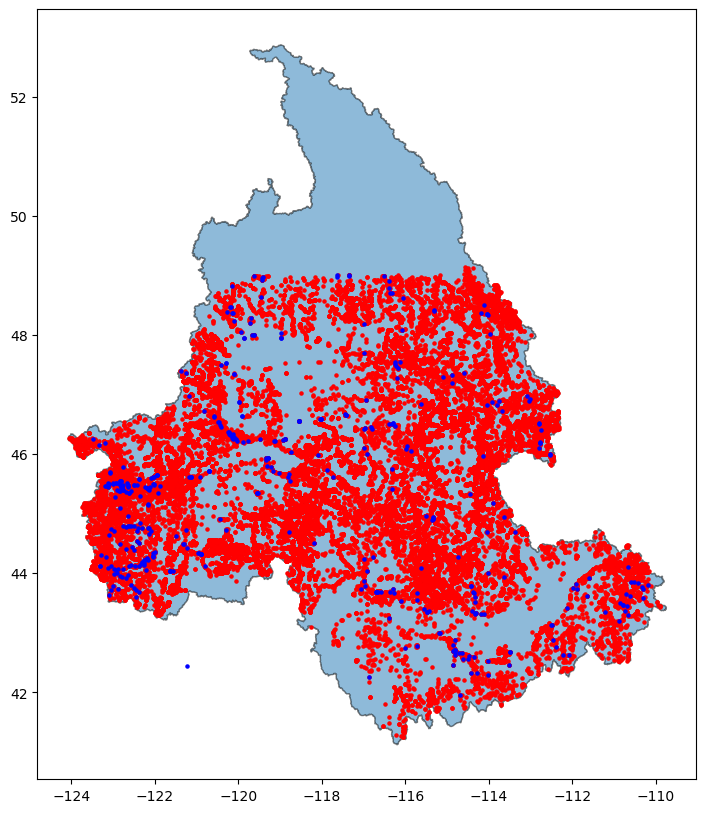

In [6]:
# plot the sites within the shapefile and the shapefile
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
sites_within.plot(ax=ax, color='red', markersize=5)
temp_gdf.plot(ax=ax, color='blue', markersize=5)


In [36]:
# load the stream temperature data
stream_temp = pd.read_csv("/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/01-Hydrothermal History/Methods/data_retrieval/conus_stream_temp/daily_stream_temperature.csv")

# filter the stream temperature data to only include sites within the shapefile
stream_temp_within = stream_temp[stream_temp.site_id.isin(sites_within.site_id)]

/var/folders/0q/tm370x9d1qdg6nt3w7pcqh_w0000gq/T/ipykernel_91065/233417646.py:2: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  stream_temp = pd.read_csv("/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/01-Hydrothermal History/Methods/data_retrieval/conus_stream_temp/daily_stream_temperature.csv")


In [37]:
# load metadata json for the stream temperature data
with open("/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/01-Hydrothermal History/Data/timeseries/USGSCONUS_Curatede/metadata.json") as f:
    conus_stream_temp_metadata = json.load(f)

parameter_codes = {
    "max water temperature (C)": "Maximum water temperature, degrees Celsius",
    "min water temperature (C)": "Minimum water temperature, degrees Celsius",
    "avg water temperature (C)": "Mean water temperature, degrees Celsius",
    "avg discharge (cfs)": "Discharge, cubic feet per second",
    "avg discharge (m3/d)": "Discharge, cubic meters per day",
}

In [47]:
startDate = "1999-01-01"
endDate = "2023-05-30"

# group the stream temperature data by site, filter to date and save each site as a csv file
for site in stream_temp_within.site_id.unique():
    site_data = stream_temp_within[stream_temp_within.site_id == site]
    site_data = site_data[(site_data.date >= startDate) & (site_data.date <= endDate)]
    if not site_data.empty:
        

        site_data = site_data.rename(
            columns={
                "mean_temp_degC": "avg water temperature (C)",
                "min_temp_degC": "min water temperature (C)",
                "max_temp_degC": "max water temperature (C)",
            }
        )

        # drop null columns
        site_data = site_data.dropna(axis=1, how="all")
        parameters = {}
        for col in site_data.columns:
            if col in parameter_codes.keys():
                parameters[col] = parameter_codes[col]

        site_data.to_csv(
            f"/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/01-Hydrothermal History/Data/timeseries/USGSCONUS_Curatede/{site}.csv",
            index=False,
        )

        # update the metadata
        conus_stream_temp_metadata["stations"][site] = {
            "source": sites_within[sites_within.site_id == site]["source"].values[0],
            "id": site,
            "description": site,
            "latitude": sites_within[sites_within.site_id == site]["latitude"].values[0],
            "longitude": sites_within[sites_within.site_id == site]["longitude"].values[0],
            "parameters": parameters,
            "geometry": {"type": "Point", "coordinates": [sites_within[sites_within.site_id == site]["longitude"].values[0], sites_within[sites_within.site_id == site]["latitude"].values[0]]},
        }
        
# save the metadata
conus_stream_temp_metadata["last_updated"] = pd.Timestamp.now().strftime("%Y-%m-%d")
conus_stream_temp_metadata["last_updated_by"] = "George Darkwah"
conus_stream_temp_metadata["last_updated_by_email"] = "gdarkwah@uw.edu"

# save the metadata
with open("/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/01-Hydrothermal History/Data/timeseries/USGSCONUS_Curatede/metadata.json", "w") as f:
    json.dump(conus_stream_temp_metadata, f, indent=4)